# SMS Spam Detection
### by Jason Paul Miller
#### 03/14/23 PI Day

# Important Imports

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # removes false positive warning
import matplotlib.pyplot as plt
import re # Text cleanup
import string # Text cleanup
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from sklearn.metrics import mean_squared_error

### Read in the data

In [16]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


### Clean up the data

In [17]:
# Remove unnecessary columns
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
print(data.shape)
data

(5572, 2)


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [18]:
# Remove any duplicates
data = data.drop_duplicates()
print(data.shape)

(5169, 2)


In [19]:
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Text Cleaning
data.loc[:, 'v2'] = data['v2'].apply(clean_text)

### Visualize the data

Text(0.5, 1.0, 'Count of Ham and Spam Messages')

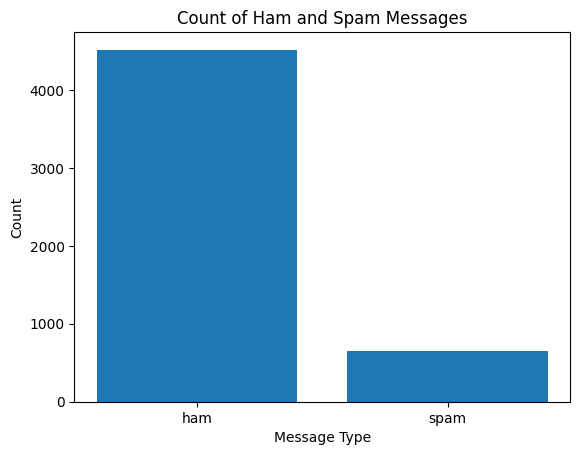

In [20]:
# Count the number of 'ham' and 'spam' messages
ham_count = (data['v1'] == 'ham').sum()
spam_count = (data['v1'] == 'spam').sum()

# Plot a bar chart of the counts
labels = ['ham', 'spam']
counts = [ham_count, spam_count]
plt.bar(labels, counts)
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.title('Count of Ham and Spam Messages')

### Split the Data 

In [21]:
# Randomize the rows
data = data.sample(frac=1, random_state=42)

# Split the data into training and test sets
train_data = data[:int(0.9*len(data))]
test_data = data[int(0.9*len(data)):]

# Print the shapes of the training and test sets
print('Training data shape:', train_data.shape)
print('Test data shape:', test_data.shape)

Training data shape: (4652, 2)
Test data shape: (517, 2)


### Word Embedding

In [22]:
# Train the model
model = Word2Vec(train_data['v2'], vector_size=100, window=5, min_count=1, workers=4)

# Create a dictionary that maps each word to its corresponding vector representation
word_vectors = model.wv

# Convert each text into a fixed-length vector by taking the mean of the word vectors
text_vectors = []
for text in train_data['v2']:
    words = text.split()
    vectors = []
    for word in words:
        if word in word_vectors.key_to_index:
            vectors.append(word_vectors.get_vector(word))
    if len(vectors) > 0:
        text_vector = np.mean(vectors, axis=0)
    else:
        text_vector = np.zeros(100)
    text_vectors.append(text_vector)

X_train = np.array(text_vectors)
y_train = np.array([1 if label == 'spam' else 0 for label in train_data['v1']])

##### Do the same for the test data

In [23]:
# Train the model
model = Word2Vec(test_data['v2'], vector_size=100, window=5, min_count=1, workers=4)

# Create a dictionary that maps each word to its corresponding vector representation
word_vectors = model.wv

# Convert each text into a fixed-length vector by taking the mean of the word vectors
text_vectors = []
for text in test_data['v2']:
    words = text.split()
    vectors = []
    for word in words:
        if word in word_vectors.key_to_index:
            vectors.append(word_vectors.get_vector(word))
    if len(vectors) > 0:
        text_vector = np.mean(vectors, axis=0)
    else:
        text_vector = np.zeros(100)
    text_vectors.append(text_vector)

X_test = np.array(text_vectors)
y_test = np.array([1 if label == 'spam' else 0 for label in test_data['v1']])

### Train a CNN

In [24]:
# Create a simple CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=1, activation='sigmoid'))

# Reshape X to a 3D numpy array with shape (num_samples, num_timesteps, num_features)
X_reshaped = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))

# Train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_reshaped, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
117/117 [==============================] - 1s 2ms/step - loss: 0.5231 - accuracy: 0.8449 - val_loss: 0.4235 - val_accuracy: 0.8668
Epoch 2/10
117/117 [==============================] - 0s 1ms/step - loss: 0.4005 - accuracy: 0.8705 - val_loss: 0.3996 - val_accuracy: 0.8668
Epoch 3/10
117/117 [==============================] - 0s 1ms/step - loss: 0.3894 - accuracy: 0.8705 - val_loss: 0.3940 - val_accuracy: 0.8668
Epoch 4/10
117/117 [==============================] - 0s 1ms/step - loss: 0.3853 - accuracy: 0.8705 - val_loss: 0.3904 - val_accuracy: 0.8668
Epoch 5/10
117/117 [==============================] - 0s 1ms/step - loss: 0.3823 - accuracy: 0.8705 - val_loss: 0.3877 - val_accuracy: 0.8668
Epoch 6/10
117/117 [==============================] - 0s 1ms/step - loss: 0.3795 - accuracy: 0.8705 - val_loss: 0.3854 - val_accuracy: 0.8668
Epoch 7/10
117/117 [==============================] - 0s 1ms/step - loss: 0.3776 - accuracy: 0.8705 - val_loss: 0.3832 - val_accuracy: 0.8668
Epoch 

### Test our model

In [25]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()

# Calculate the MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Compare the predicted labels with the actual labels
accuracy = (y_pred == y_test).mean()
print('Accuracy:', accuracy)

17/17 [==============================] - 0s 510us/step
MSE: 0.09090909090909091
Accuracy: 0.9090909090909091
